In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Import generic libraries
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io
import os, sys
import tqdm
from scipy.optimize import curve_fit
from pathlib import Path
import pickle

In [5]:
# Import local tools
sys.path.append(os.path.expanduser('~/Documents/MULTIBAR_Analysis/kohl-lab-pynalysis/'))
from pynalysis import utils

In [4]:
# sys.path.append(os.path.expanduser('/home/zenke/projects/2017-kohl/tensortools/'))
# import tensortools as tt

In [6]:
# Import local OASIS installation
sys.path.append(os.path.expanduser('~/Documents/MULTIBAR_Analysis/OASIS-master/'))
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis import oasisAR1, oasisAR2

In [7]:
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso

In [8]:
def datamatrix2tensor(data, event_times, toff_after, toff_before=0):
    """ Slices flat data matrix into trial based tensor.
    
    Expects data to be time x unit.
    
    Returns: A tuple of (list, tensor) in which the list contains the indices of valid trials (ie. the ones
    for which the time interval was valid) and the tensor contains the data in format trial x time x unit.
    """
    trials = []
    indices = [] 
    nb_frames = data.shape[0]
    for i,ev in enumerate(event_times):
        fr = int(ev)
        if fr<toff_before or fr>nb_frames-toff_after: continue
        s = data[fr-toff_before:fr+toff_after]
        trials.append(s)
        indices.append(i)
    return indices, np.array(trials)

In [9]:
def tensorbin(data, bin_size=10):
    """ Takes data tensor and bins it """
    nb_bins = data.shape[1]//bin_size
    #print(data.shape)
    binned = []
    for i in range(nb_bins):
        a = data[:,i*bin_size:(i+1)*bin_size,:]
        # print(a.shape)
        binned.append(np.sum(a,axis=1))
    return np.transpose(np.array(binned),axes=[1,0,2])
    
def bin_data(data, event_times, toff_after=60, toff_before=0, bin_size=10, axis=1):
    datatensor = datamatrix2tensor(data,event_times,toff_before=toff_before, toff_after=toff_after)
    #     return datatensor.mean(axis=axis)
    return tensorbin(datatensor, bin_size)

In [10]:
def split_dataset(dataset, split=0.8, shuffle=False):
    x,y = dataset
    n = len(x)
    s = int(split*n)
    idx = np.arange(len(x))
    if shuffle: np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:s]
    x_valid = x[s:]
    y_train = y[:s]
    y_valid = y[s:]
    return (x_train, y_train),(x_valid, y_valid)

In [11]:
def fuse_dataset(data, labels):
    d = data.reshape((data.shape[0],-1))
    return d,labels

In [12]:
def get_acc(dataset):
    pred=svc.predict(dataset[0])
    acc=(pred==dataset[1]).mean()
    return acc

In [13]:
def get_acc_all_times(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC over all times
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    dataset = fuse_dataset(data_selection,labels)
    clf = SVC(kernel=kernel, C=1)
    scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
    return scores

def scan_acc_time(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC on each time slice from datatensor
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer over time.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    results = []
    for t in range(data_selection.shape[1]):
        partial_data = data_selection[:,t,:]
        dataset = fuse_dataset(partial_data,labels)
        clf = SVC(kernel=kernel, C=1)
        scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
        results.append(scores)
    results = np.array(results)
    return results

# Main program

In [18]:
# Load external list of animals and experiments
experiments = pd.read_csv("~/Documents/MULTIBAR_Analysis/kohl-lab-pynalysis/meta_data/MULTIBAR-animal-list.csv")

In [14]:
# utils.save_zipped_pickle(data_packs,"~/data/kohl/preprocessed/preprocessed_data.pkl.gz")

In [17]:
# Load preprocessed data from zipped pickle
data_packs = utils.load_zipped_pickle(os.path.expanduser("~/Desktop/Results/preprocessed/preprocessed_data.pkl.gz"))

# Extract accuracy with SVM

In [15]:
def standardize(data):
    shp = data.shape
    scaler = sklearn.preprocessing.Normalizer()
    return scaler.fit_transform(data.reshape(data.shape[0],-1)).reshape(shp)

In [16]:
# Load datapacks run SVM and create pandas dataframe with the results
records = []
for area in data_packs:
    for plane in range(2):
        data = area['plane_data'][plane]['datatensor']
        labels = area["labels"]

        string_identifier = "%s/%s/plane%i"%(area["stringid"],area["expspecifier"],plane+1)
        print(string_identifier)
        
        nb_stimuli = len(np.unique(labels))
        chance_level = 1.0/nb_stimuli

        # perform min max scaling on a per neuron basis
        # mi = area["plane_data"][plane]['traces'].min(0)
        # ma = area["plane_data"][plane]['traces'].max(0)
        # sd = area["plane_data"][plane]['traces'].std(0)
        # data = (data-mi)/(ma-mi+1e-7)
        # data = data/(sd+1e-7)
        
        # check for nan in data
        if np.isnan(data.mean()):
            print("Warning dataset contains NAN. Skipping...")
            continue

        # Process time averaged trial data
        trialdata = standardize(data[:,15:45,:].mean(1))
        print("Total number of trials %i"%trialdata.shape[1])
        dataset = fuse_dataset(trialdata,labels)
        
        clf = SVC(kernel="linear", C=1)
        svm_scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
        
        acc2s_mean_score   = svm_scores.mean()
        acc2s_stdev_score  = svm_scores.std()
        print("Mean score %f"%acc2s_mean_score)
        
        
        # Running speed prediction
        alpha = 1e-3
        lasso = Lasso(alpha=alpha)

        # area['mean_trial_velocity'].std()
        trialdata = standardize(data[:,15:45,:].mean(1))
        dataset = (trialdata, area['mean_trial_velocity'])
        lasso_scores = []
        for i in range(20):
            trainset, testset = split_dataset(dataset, shuffle=True)
            lasso.fit(*trainset)
            y_pred_lasso = lasso.predict(testset[0])
            r2_score_lasso = r2_score(testset[1], y_pred_lasso)
            lasso_scores.append(r2_score_lasso)
        # scorer=sklearn.metrics.make_scorer(r2_score)
        # lasso_scores = cross_val_score(lasso, dataset[0], dataset[1], cv=5)
        # print(lasso)
        lasso_scores = np.array(lasso_scores)
        r2_score_lasso = lasso_scores.mean()
        print("r^2 on test data : %f" % r2_score_lasso)

        
        # import fields from experiments CSV file
        ex = experiments.loc[area["index"]]
        
        # combine results to record
        rec = dict( stringid=area["stringid"], 
                    exp_date=area["exp_date"], 
                    area_name=area["area_name"],
                    plane_number=plane+1,
                    nb_stimuli=nb_stimuli,
                    chance_level=chance_level,
                    svm_acc_mean=acc2s_mean_score, 
                    svm_acc_stdev=acc2s_stdev_score,
                    lasso_r2_mean=lasso_scores.mean(),
                    lasso_r2_stdev=lasso_scores.std(),
                    mean_velocity=area['mean_trial_velocity'].mean(),
                    plane1_layer=ex["plane1_layer"],
                    plane2_layer=ex["plane2_layer"],
                    nb_stim_pos=ex["nb_pos"],
                    nb_stim_speed=ex["nb_speed"],
                    indicator=ex["indicator_name"],
                    comments=ex["comments"],
                  )
        
        records.append(rec)
        
df = pd.DataFrame(records)

NameError: name 'data_packs' is not defined

In [18]:
df.to_csv("acc_data4pooling.csv")

# Stimulus decoding accuracy

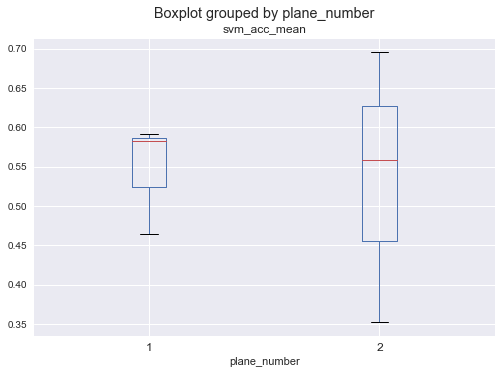

In [19]:
# Layer 2/3 comparison in stimulus decoding accuracy single animal
sel = df.loc[(df["stringid"]=="CGCC8.5a") & (df["plane1_layer"]==2) & (df["plane2_layer"]==3) 
             & (df["nb_stim_speed"]==1) & (df["nb_stim_pos"]==4)]
sel.boxplot(column="svm_acc_mean", by="plane_number")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x106819358>]], dtype=object)

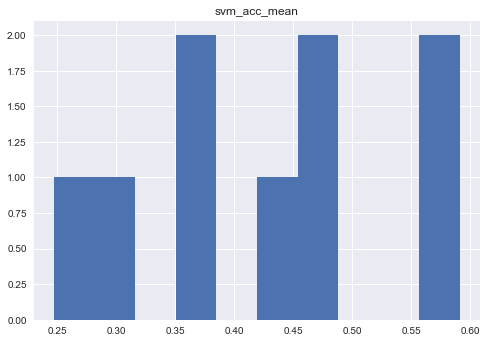

In [20]:
# Layer 2/3 comparison in stimulus decoding accuracy single animal
sel1 = df.loc[(df["nb_stimuli"]==4) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3) & (df["plane_number"]==1) ]
sel2 = df.loc[(df["nb_stimuli"]==4) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3) & (df["plane_number"]==2) ]
sel1.hist(column=["svm_acc_mean"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13e1744a8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11263a978>], dtype=object)

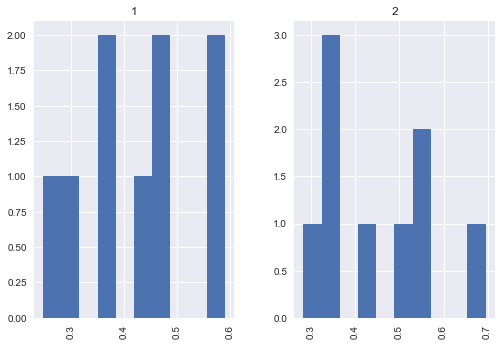

In [21]:
sel = df.loc[(df["plane1_layer"]==2) & (df["plane2_layer"]==3) 
             & (df["nb_stim_speed"]==1) & (df["nb_stim_pos"]==4)]
sel.hist(column="svm_acc_mean", by="plane_number")

In [22]:
sel1 = df.loc[(df["nb_stimuli"]==4) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3) ]

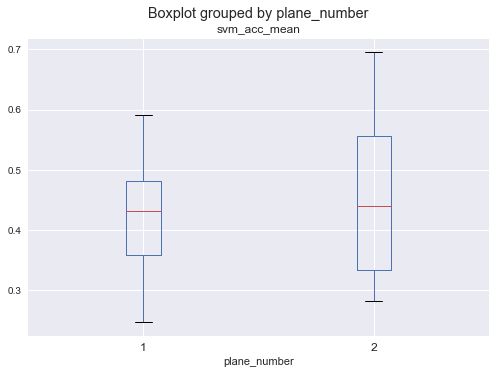

In [23]:
# Layer 2/3 comparison in stimulus decoding accuracy (all Layer2/3 data)
sel = df.loc[(df["nb_stimuli"]==4) & (df["nb_stim_speed"]==1) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3) ]
sel.boxplot(column="svm_acc_mean", by="plane_number")

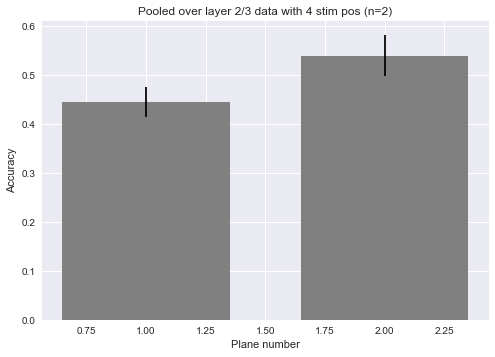

In [39]:
# Similar plot but taking into account the individual data point errors and then plotting the aggregate SEM as error bar
means = []
stdvs = []
for plane in range(2):
    sel = df.loc[(df["nb_stimuli"]==4) & (df["plane1_layer"]==3) & (df["plane2_layer"]==3) & (df["plane_number"]==plane+1)]
    means.append(sel["svm_acc_mean"].mean())
    stdvs.append(np.sqrt(np.square(sel["svm_acc_stdev"]).sum())/len(sel["svm_acc_stdev"]))
    
ind = list(range(1,3))
width = 0.7
ax = plt.subplot(1,1,1)
plt.title("Pooled over layer 2/3 data with 4 stim pos (n=%i)"%(len(sel)))
p1 = plt.bar(ind, means, width, yerr=stdvs/np.sqrt(len(stdvs)), color='gray')
ax.set_xlabel("Plane number")
ax.set_ylabel("Accuracy")
sns.despine()

In [40]:
len(sel)

2

# Selecting for units above chance

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ab57e9128>,
      dtype=object)

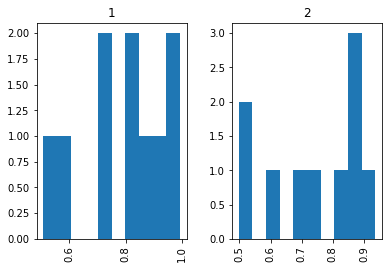

In [60]:
# Layer 2/3 comparison in stimulus decoding accuracy (all Layer2/3 data)
sel = df.loc[(df["nb_stimuli"]==2) & (df["nb_stim_speed"]==1) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3) ]
sel.hist(column="svm_acc_mean", by="plane_number")

In [61]:
above_chance = sel.loc[sel["svm_acc_mean"]-3*sel["svm_acc_stdev"]>sel["chance_level"]]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ab56e53c8>,
      dtype=object)

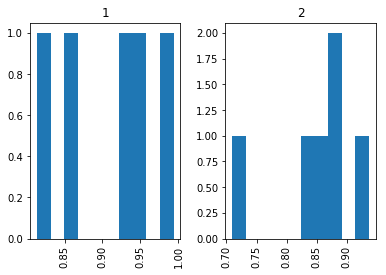

In [62]:
above_chance.hist(column="svm_acc_mean", by="plane_number")

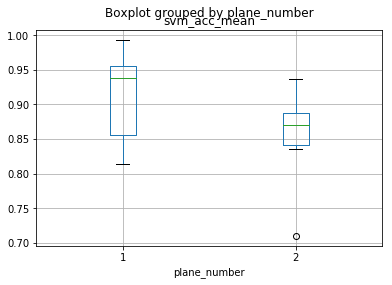

In [63]:
above_chance.boxplot(column="svm_acc_mean", by="plane_number")

# Running speed decoding

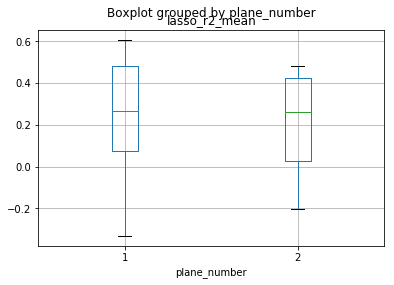

In [64]:
# Layer 2/3 comparison in decoding accuracy of running speed
sel = df.loc[(df["nb_stimuli"]==2) & (df["nb_stim_speed"]==1) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3)]
sel.boxplot(column="lasso_r2_mean", by="plane_number")
# plt.ylim(0,1)

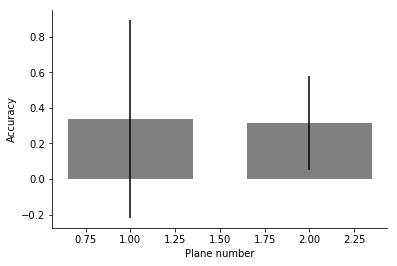

In [65]:
# Similar plot but taking into account the individual data point errors and then plotting the aggregate SEM as error bar
means = []
stdvs = []
for plane in range(2):
    sel = df.loc[(df["nb_stimuli"]==2) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3) & (df["plane_number"]==plane+1)]
    means.append(sel["lasso_r2_mean"].mean())
    stdvs.append(np.sqrt(np.square(sel["lasso_r2_stdev"]).mean()))
    
ind = list(range(1,3))
width = 0.7
ax = plt.subplot(1,1,1)
p1 = plt.bar(ind, means, width, yerr=stdvs/np.sqrt(len(stdvs)), color='gray')
ax.set_xlabel("Plane number")
ax.set_ylabel("Accuracy")
sns.despine()